In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import glob
import numpy as np

In [2]:
#Getting all the pictures from those files
inputs = [file for file in glob.glob("CSC498/input/*")]
masks = [file for file in glob.glob("CSC498/mask/*")]

#Parsing through the pictures to just get the number and nothing else
input_by_id = {}
for file in inputs:
    imgid = int(file.split(" ")[-1].split(".")[0])
    input_by_id[imgid] = file
mask_by_id = {}
for file in masks:
    imgid = int(file.split("_")[-1].split("-")[0])
    mask_by_id[imgid] = file
    
#We will be using these as the test 
test_id = [76, 17, 42]

In [3]:
import cv2

In [4]:
imgs = []
masks = []

#Other than the tests resize the pictures and get the blue color
for i, file in input_by_id.items():
    if i not in test_id:
        img = cv2.imread(file)
        resized = cv2.resize(img, dsize=(150, 200), interpolation=cv2.INTER_CUBIC)
        mask = cv2.imread(mask_by_id[i])[:,:,2]
        mask = cv2.resize(mask, dsize=(150, 200), interpolation=cv2.INTER_CUBIC)
        imgs.append(resized)
        masks.append(mask)

#If blue exists then its 1 and if not its 0
imgs = np.stack(imgs) / 255
masks = np.stack(masks) / 255

In [5]:
imgs.shape # [49, 400, 300, 3]

(49, 200, 150, 3)

In [6]:
x = torch.tensor(imgs, dtype=torch.float32).transpose(1,3).transpose(2,3)

In [7]:
x.shape

torch.Size([49, 3, 200, 150])

In [8]:
masks = torch.tensor(masks, dtype=torch.float32)

In [9]:
import torchvision.models
#Pretrained convolutions
alexnet = torchvision.models.alexnet(pretrained=True)

In [10]:
alexnet.features(x).shape

torch.Size([49, 256, 5, 3])

In [11]:
8*3*5

120

In [12]:
class Steven(nn.Module):
    def __init__(self):
        super(Steven, self).__init__()
        self.conv = nn.Conv2d(256, 10, 1)
        self.linear = nn.Linear(10*3*5, 150*200)
        
    def forward(self, x):
        alexnetout = alexnet.features(x)
        convout = self.conv(alexnetout)
        convout = convout.view(-1, 10*3*5)
        return self.linear(convout).view(-1, 200, 150)

model = Steven()

In [13]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [29]:
for it in range(10):
    out = model(x)
    loss = criterion(out.view(-1), masks.view(-1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if it%50 == 0:
        print(it, float(loss))
print ("Done")

0 0.002612318843603134
Done


In [30]:
out.shape

torch.Size([49, 200, 150])

In [31]:
ypred = out.detach().numpy()

In [32]:
ypred[0,:2,:2]

array([[-22.058151, -21.946224],
       [-22.43112 , -25.030182]], dtype=float32)

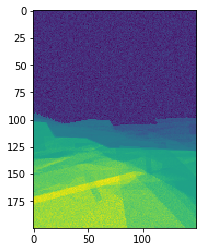

In [33]:
plt.imshow(ypred[0])

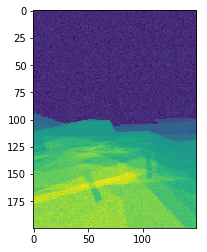

In [34]:
plt.imshow(ypred[1])

(49, 200, 150)

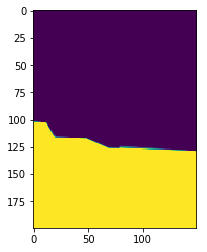

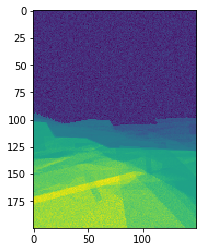

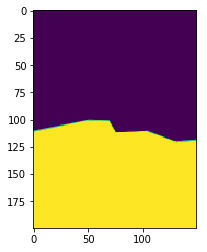

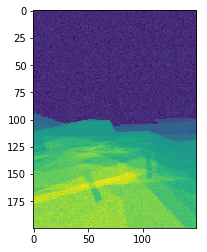

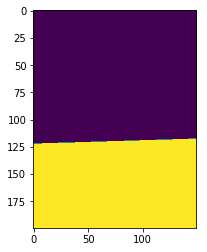

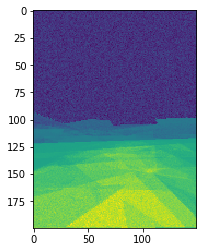

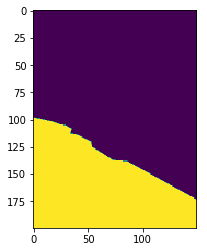

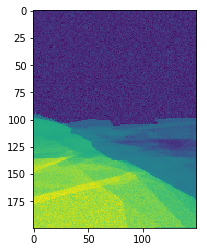

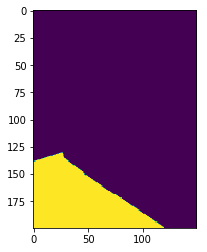

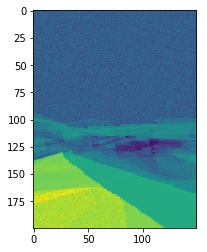

In [35]:
for i in range(5):
    plt.figure()
    plt.imshow(masks[i])
    plt.figure()
    plt.imshow(ypred[i])
ypred.shape

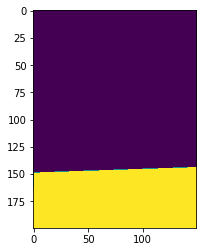

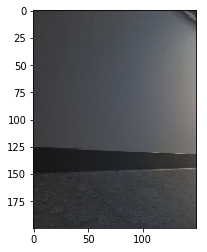

In [21]:
plt.imshow(masks[10])
plt.figure()
plt.imshow(imgs[10])